# Visualizing SWMM Models
Let's explore how we can quickly visualize SWMM models using swmmio and some other familiar tools. We'll start by instantiating a larger model hosted in the [NCIMM-White-Box-Testing](https://github.com/SWMMEnablement/NCIMM-White-Box-Testing) repository. Note that we can do the same with models stored locally on your system.

In [12]:
import swmmio

# url to the inp file hosted on GitHub
URL = 'https://raw.githubusercontent.com/SWMMEnablement/NCIMM-Black-White-Box/25a7dc8fc58f67d15954679f294d09b9061766a4/SWMM5_NCIMM/10070_H_Elements.inp'

# instatiate a model object by passing in a URL 
model = swmmio.Model(URL)

Now that we have an interesting model to work with, we can visualize the sewer network with some tools built-in to swmmio. The {py:func}`swmmio.draw_model` function generates a quick visualization of the network: 

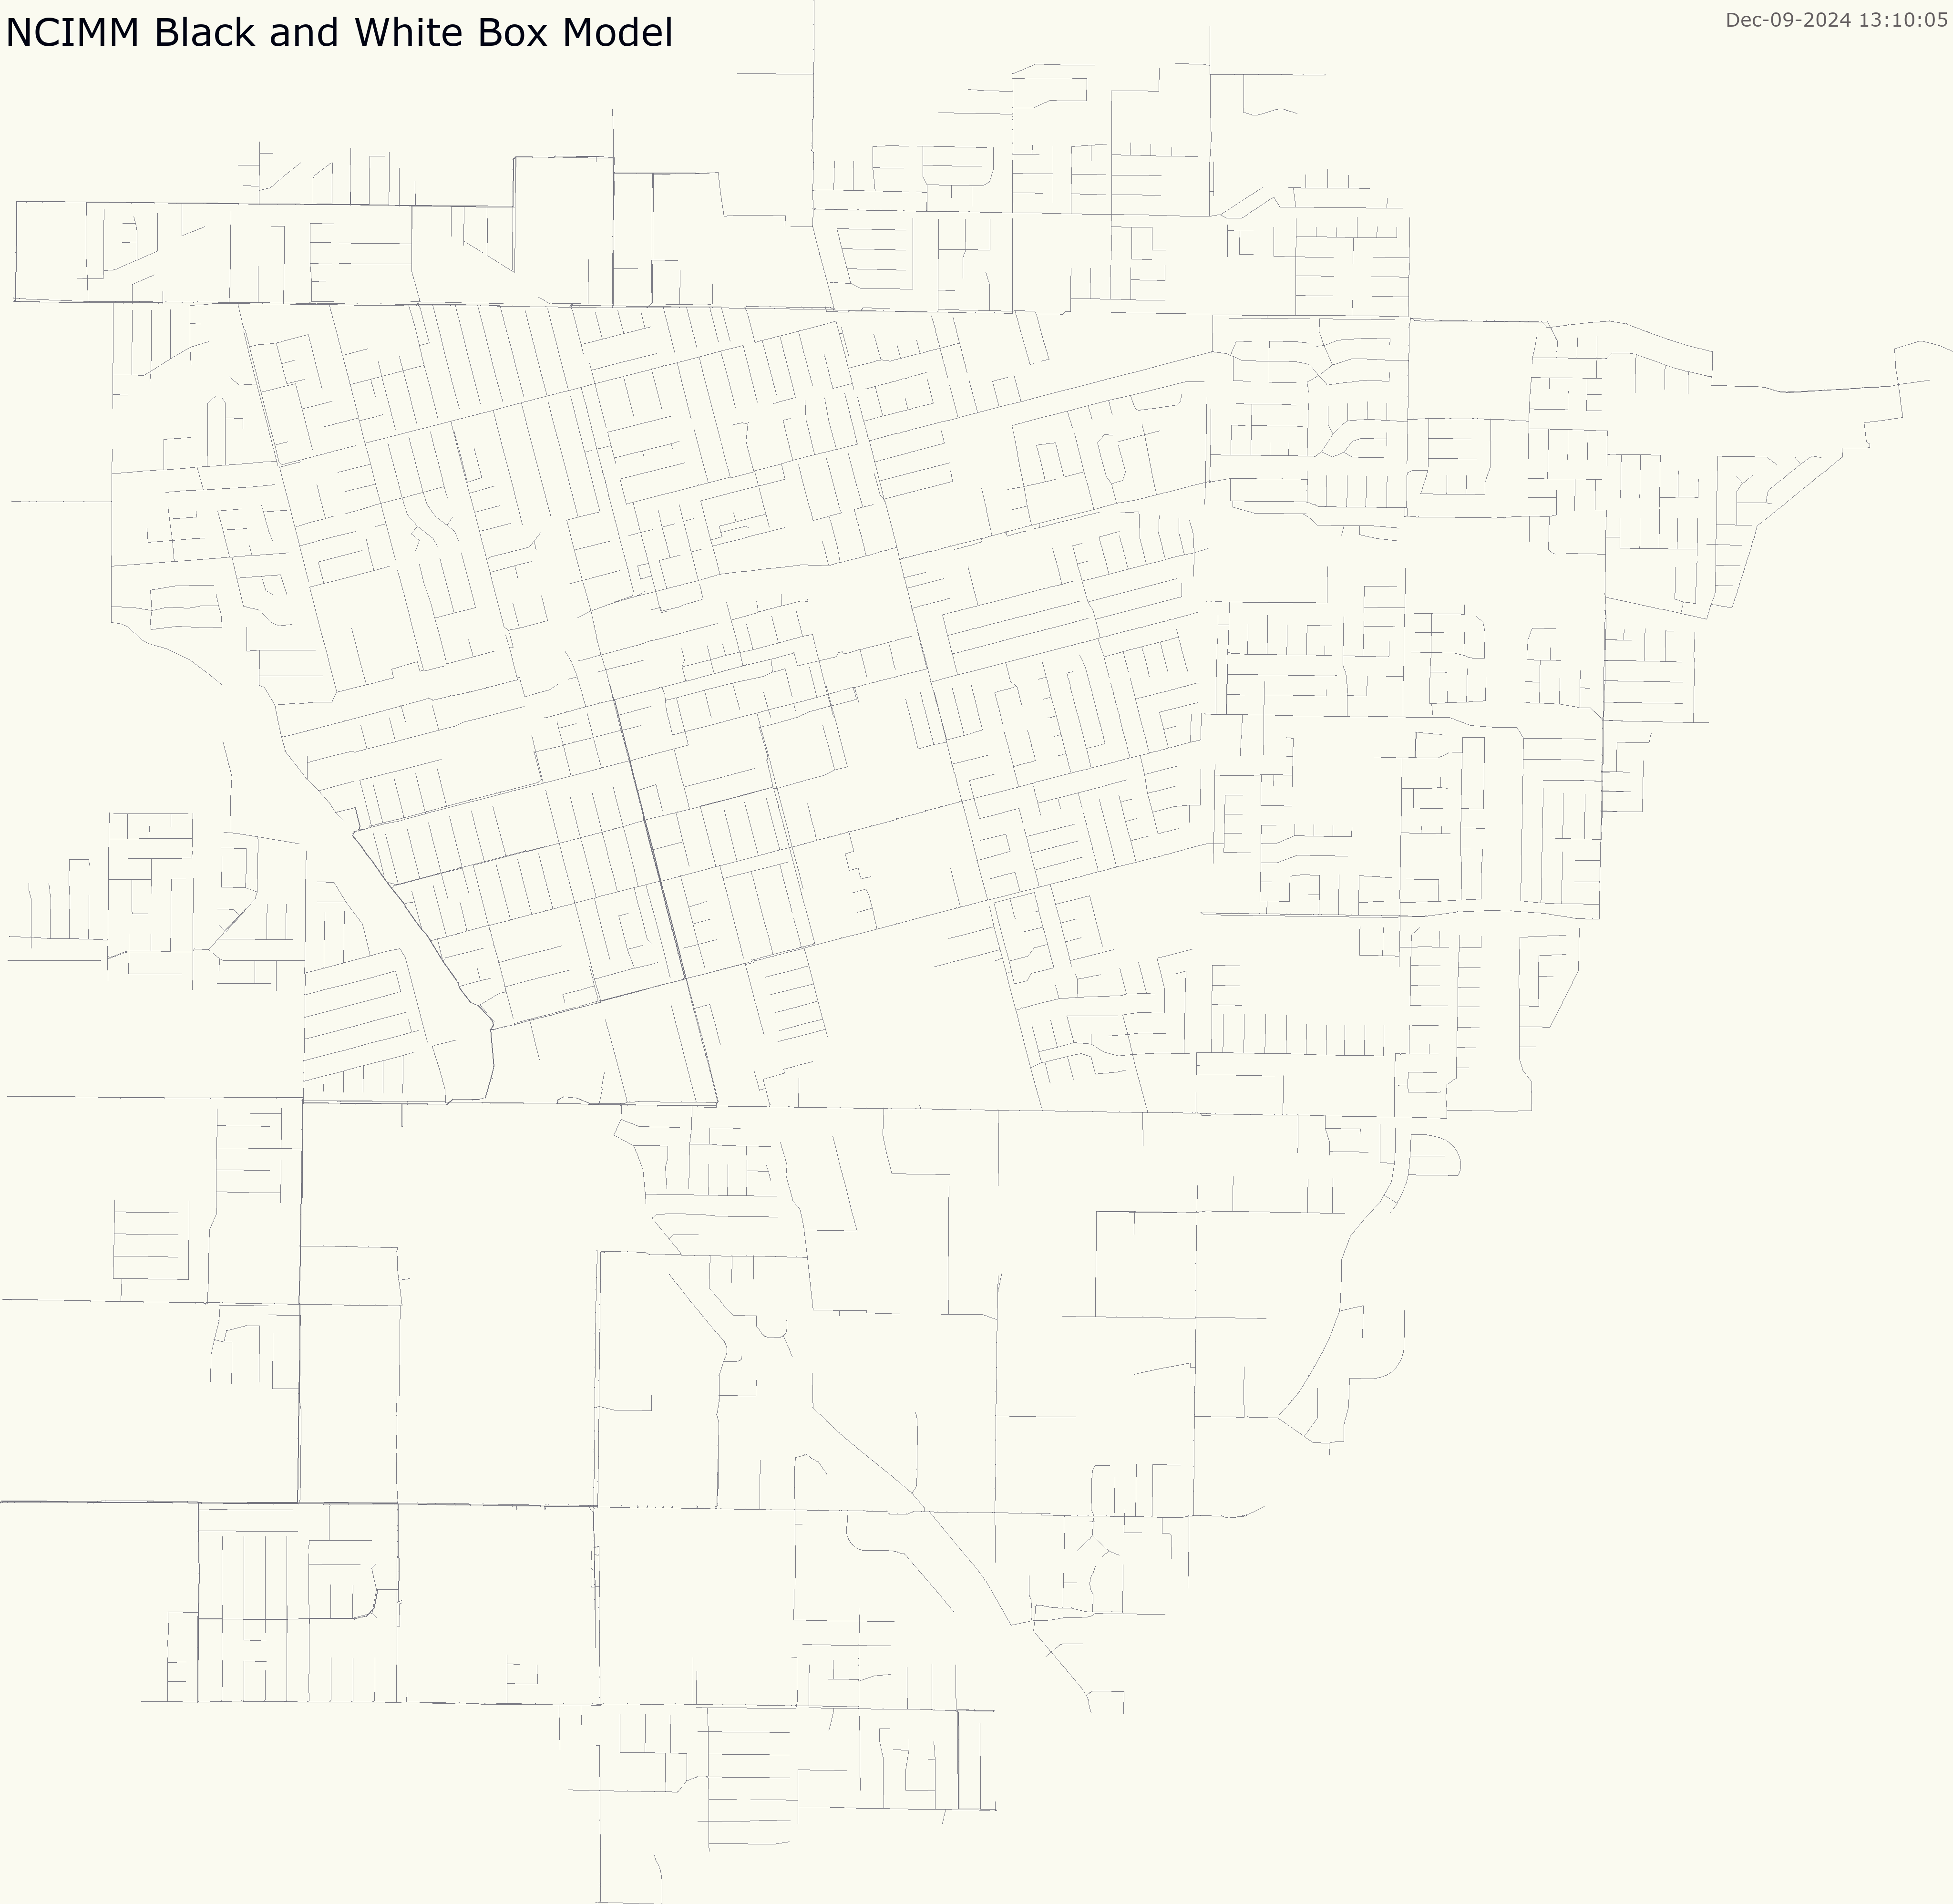

In [2]:
swmmio.draw_model(model, title='NCIMM Black and White Box Model')

Not bad, but we can do better. Let's use the {py:func}`swmmio.Model.links.geodataframe` method, which returns a GeoDataFrame object containing all model links. With this, we can tap into the `.plot()` method which opens up a ton of familiar functionality via matplotlib.

<Axes: >

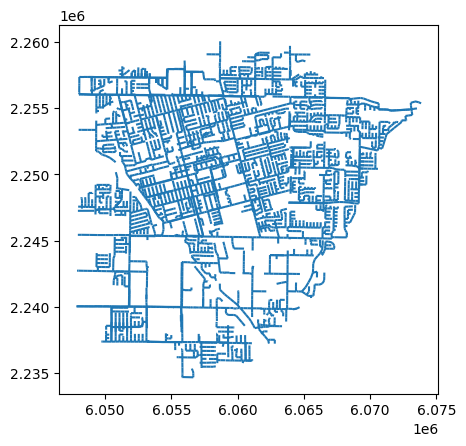

In [3]:
# basic plot of the model's links
model.links.geodataframe.plot()

Let's add some styling by making the link linewidth a function of GEOM1, and visualize where the outfalls are. 

<Axes: >

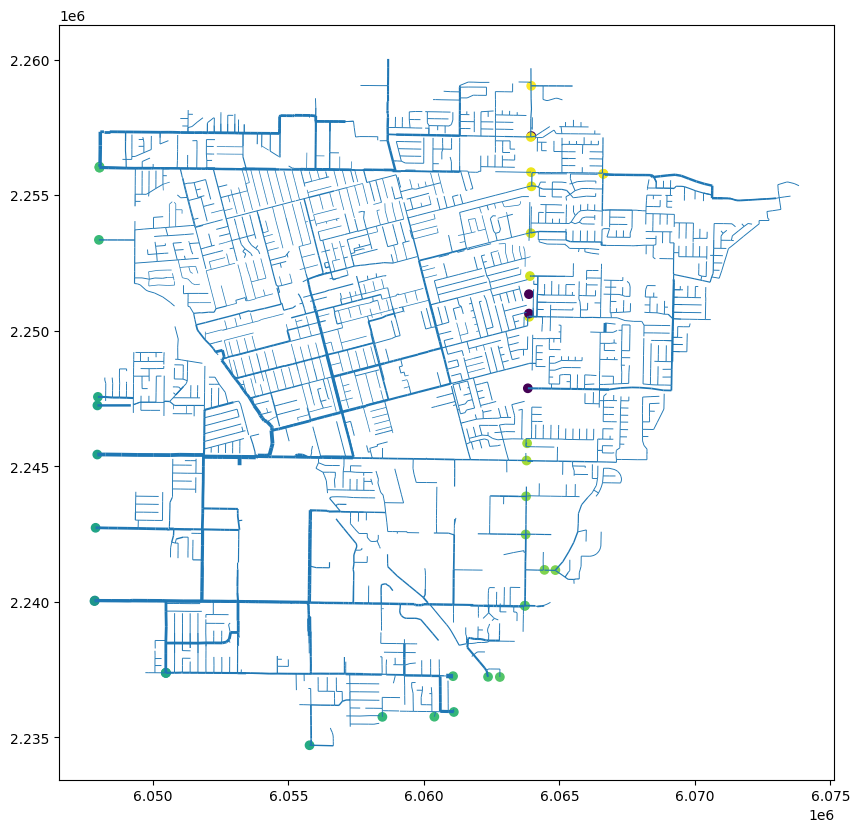

In [4]:
# grab the list of outfalls
outfalls = model.inp.outfalls

# draw the model links and outfalls
ax = model.links.geodataframe.plot(linewidth=model.links.dataframe['Geom1'], figsize=(10,10))
model.nodes.geodataframe.loc[outfalls.index].plot('InvertElev', ax=ax)

## Finding Important Outfalls
Let's visualize outfalls in a way that emphaisizes their "importance" in the hydraulic netowrk. Here, we say an outfall is more important if more of the hydraulic network drains to (or has a path to) a particular outfall. 

To accomplish this, we'll leverage the {py:func}`swmmio.Model.network` method to get a NetworkX MultiDiGraph represenation of the model. Then, we'll count the number of nodes that are anscestors of (i.e. drain to) each outfall. 

In [13]:
import networkx as nx

# get the networkx graph representation of the model
G = model.network

# grab the list of outfalls
outfalls = model.inp.outfalls

# get a count of nodes upstream of each outfall
outfalls['anscestors'] = outfalls.apply(lambda x: len(nx.ancestors(G, x.name)), axis=1)
outfalls.sort_values(by='anscestors', ascending=False).head(n=10)

,InvertElev,OutfallType,StageOrTimeseries,anscestors
Name,,,,
OT058435,99.069000,FREE,NO,2201
SW057333,96.186479,FREE,NO,2134
SW050430,91.518354,FREE,NO,2129
OT057101,106.086000,FREE,NO,1866
OT055333,105.243018,FREE,NO,1753
SW052128,128.070000,FREE,NO,669
OT114327,0.000000,FREE,NO,344
SW058436_OUT1,102.400000,FREE,NO,183
OC-SYCAMORE,175.500000,FREE,NO,163


Now that we have a measure of outfall "importance", let's visualize things in a map.

<Axes: >

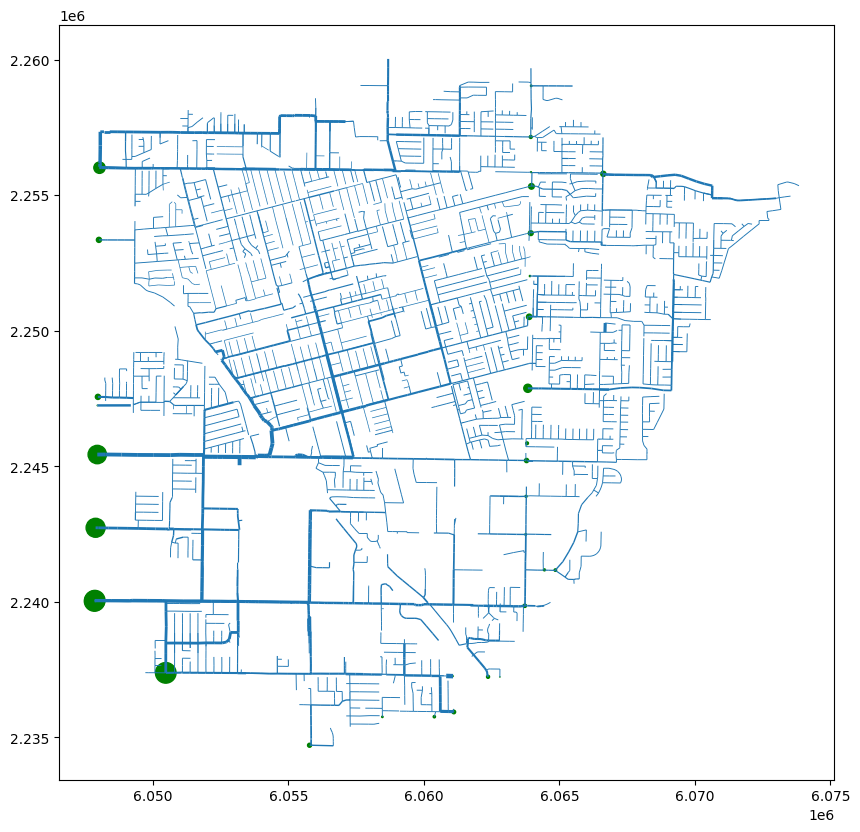

In [6]:

ax = model.links.geodataframe.plot(linewidth=model.links.dataframe['Geom1'], figsize=(10,10))
model.nodes.geodataframe.loc[outfalls.index].plot(markersize=outfalls['anscestors'] / 10, ax=ax, color='green')

## Highlighting a Sub-Watershed
Let's visualize all of the elements of the model that drain into the `OT058435` outfall. To accomplish this, we'll again use the {py:func}`swmmio.Model.network` and 

1. find all of the model junctions that drain into the outfall of interest, then
2. get a list of all model edges that are adjacent to these junctions. 

We can then color the edges according to whether or not they drain to our outfall of interest. We'll also add some anotations describing the location of the outfall and a few stats about the sub-watershed.

In [14]:
links = model.links.geodataframe.copy()
nodes = model.nodes.geodataframe.copy()

Text(6074282.675179872, 2234263.832552967, 'Total Sewer Length: 82 miles\nMaximum Diameter: 33.0 inches\nNumber of Links: 1778\nNumber of Nodes: 1753\n')

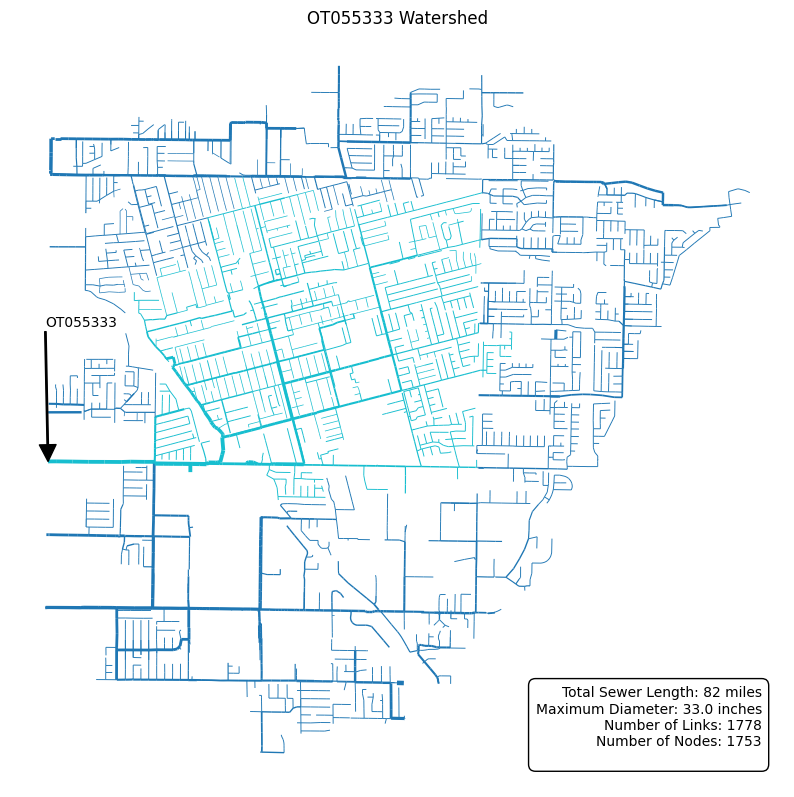

In [ ]:
outfall = 'OT055333'
water_shed_junctions = nx.ancestors(G, outfall)
ws_edges = [k for _, _, k in G.edges(keys=True, nbunch=water_shed_junctions)]

# links = model.links.geodataframe
links['outfall'] = links.index.isin(ws_edges)
ax = links.plot('outfall', linewidth=links['Geom1'], figsize=(10,10))

# Coordinates of the point of interest (example coordinates)
point_of_interest = model.nodes.geodataframe.loc[outfall].geometry

# Add title and hide axes
ax.set_title(f'{outfall} Watershed')
ax.set_axis_off()

# Add annotation with arrow highlighting location of outfall
ax.annotate(
    outfall, 
    xy=(point_of_interest.x, point_of_interest.y), 
    xytext=(point_of_interest.x - 100, point_of_interest.y + 5000),
    arrowprops=dict(facecolor='black', width=1)
)

# Add annotation in the bottom right part of the plot with summary stats
# Get the data limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Calculate the annotation coordinates
x_annotate = xlim[0] + 0.97 * (xlim[1] - xlim[0])
y_annotate = ylim[0] + 0.03 * (ylim[1] - ylim[0])

sub_links = links.loc[links['outfall']]

# build the summary text
summary = f"""Total Sewer Length: {sub_links['Length'].sum() / 5280:.0f} miles
Maximum Diameter: {sub_links['Geom1'].max() * 12} inches
Number of Links: {len(sub_links)}
Number of Nodes: {len(water_shed_junctions)}
"""
ax.annotate(
    summary,
    xy=(x_annotate, y_annotate),  # Coordinates for the text box
    xytext=(x_annotate, y_annotate),  # Same coordinates for text
    textcoords='data',
    bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'),
    horizontalalignment='right',
    verticalalignment='bottom'
)